**Exercise predictive modeling:**<br>
In this exercise, you recapitulate the principles of predictive modeling. You will build a predictive model for a travel 
insurance, which predicts whether a given insurance offer leads to a claim. You can use "Ex03-Python_Machine_Learning.ipynb" 
to lookup on the model building procedure and the required commands in python. 

In the next cells, we provide the code for importing required packages and for loading the data set (You need to adapt the
path to the data.). Afterwards, the exercises begin.  

In [1]:
# required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## read data
trav_ins = pd.read_csv("../data/travel insurance.csv",index_col=False,sep=',', encoding='utf-8')

In [3]:
## get to know the data
print(trav_ins.shape)
print(trav_ins.head())
trav_ins.describe(include='all')

(63326, 11)
  Agency    Agency Type Distribution Channel                     Product Name  \
0    CBH  Travel Agency              Offline               Comprehensive Plan   
1    CBH  Travel Agency              Offline               Comprehensive Plan   
2    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
3    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
4    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   

  Claim  Duration Destination  Net Sales  Commision (in value) Gender  Age  
0    No       186    MALAYSIA      -29.0                  9.57      F   81  
1    No       186    MALAYSIA      -29.0                  9.57      F   71  
2    No        65   AUSTRALIA      -49.5                 29.70    NaN   32  
3    No        60   AUSTRALIA      -39.6                 23.76    NaN   32  
4    No        79       ITALY      -19.8                 11.88    NaN   41  


,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
count,63326,63326,63326,63326,63326,63326.000000,63326,63326.000000,63326.000000,18219,63326.000000
unique,16,2,2,26,2,NaN,149,NaN,NaN,2,NaN
top,EPX,Travel Agency,Online,Cancellation Plan,No,NaN,SINGAPORE,NaN,NaN,M,NaN
freq,35119,45869,62219,18630,62399,NaN,13255,NaN,NaN,9347,NaN
mean,NaN,NaN,NaN,NaN,NaN,49.317074,NaN,40.702018,9.809992,NaN,39.969981
std,NaN,NaN,NaN,NaN,NaN,101.791566,NaN,48.845637,19.804388,NaN,14.017010
min,NaN,NaN,NaN,NaN,NaN,-2.000000,NaN,-389.000000,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,18.000000,0.000000,NaN,35.000000
50%,NaN,NaN,NaN,NaN,NaN,22.000000,NaN,26.530000,0.000000,NaN,36.000000
75%,NaN,NaN,NaN,NaN,NaN,53.000000,NaN,48.000000,11.550000,NaN,43.000000


**Exercise 1:**<br>
Impute missing values with an approach of your own choice.

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64


<AxesSubplot:xlabel='Gender', ylabel='count'>

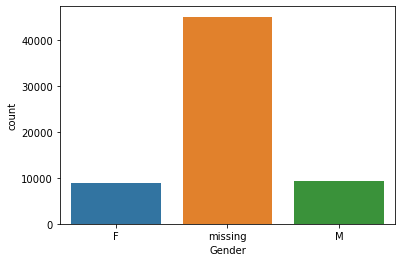

In [4]:
print(trav_ins.isnull().sum(axis=0))
trav_ins['Gender'] = trav_ins['Gender'].fillna('missing')
sns.countplot(x="Gender", data=trav_ins)

**Exercise 2:**<br>
Appropriately encode the target "Claim".

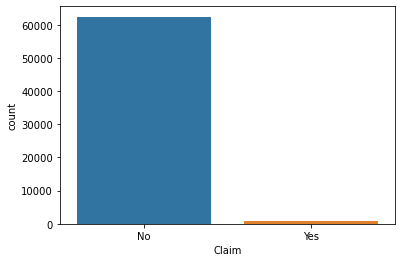

In [5]:
sns.countplot(x="Claim", data=trav_ins)
## we apply binary encoding
trav_ins['Claim']=trav_ins['Claim'].map({'Yes': 1, 'No': 0})

**Exercise 3:**<br>
Appropriately encode the categorical variables. We recommend merging categories with few observations in one group.

In [6]:
## We calculate number of observations for each destination.
## Then we replace destinations with less than 500 observations by category 'Other'. 
dest_count = trav_ins['Destination'].value_counts() 
trav_ins['Destination'] = np.where(trav_ins['Destination'].isin(dest_count[dest_count.lt(500)].index),'Other',trav_ins['Destination'])

## We first seperate features and target, to leave the target out of the encoding.
X = trav_ins.drop('Claim', axis = 1)
y = trav_ins['Claim']

## We apply one hot encoding.
X = pd.get_dummies(X, prefix_sep="_",columns=X.select_dtypes(include=[object]).columns)
X.head(10)




,Duration,Net Sales,Commision (in value),Age,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,...,Destination_PHILIPPINES,Destination_SINGAPORE,"Destination_TAIWAN, PROVINCE OF CHINA",Destination_THAILAND,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_VIET NAM,Gender_F,Gender_M,Gender_missing
0,186,-29.0,9.57,81,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,186,-29.0,9.57,71,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,65,-49.5,29.70,32,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60,-39.6,23.76,32,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,79,-19.8,11.88,41,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,66,-121.0,42.35,44,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
6,47,-39.6,23.76,32,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
7,63,-108.9,65.34,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,57,-19.8,11.88,44,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,186,-99.0,59.40,37,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Exercise 4:**<br>
Split 80% of the data in the training set and the remaining 20% data in the test set.

In [7]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5) # random state is similair to setting the seed

**Exercise 5:**<br>
Build a random forest model on the training data. Find the best tuning parameters by grid search.  
Below is a simple grid, which you could choose.

In [8]:
# - run time 2-3 min.
## example grid
param_grid = {'n_estimators': [500],
              'max_features': [4, 8, 12],
              'max_depth':[10]
              }

# grid search and fitting on the whole training set with best tuning parameters 
rf = RandomForestClassifier()
gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1)
gs_rf.fit(X_train, y_train)
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)
rf = gs_rf.best_estimator_ ## model with best parameters fitted on the whole training set

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV AUC: 0.8221
Optimal RF meta-parameters:
{'max_depth': 10, 'max_features': 4, 'n_estimators': 500}


**Exercise 6:**<br>
Evaluate the model by appropriate metrics on the test set. Is the model able to predict claims with certainty?
Is the model usefull for application?

In [9]:
rf_pred = rf.predict(X_test)
rf_pred_prob = rf.predict_proba(X_test)
rf_pred_prob = rf_pred_prob[:,1]
print('Classification Accuracy: ',   metrics.accuracy_score(y_test, rf_pred))
print("Recall:  \t\t",               metrics.recall_score(y_test, rf_pred))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, rf_pred_prob))

Classification Accuracy:  0.9845255013421759
Recall:  		 0.0
AUC: 			 0.838242598563082


Recall=0 means that the model classified each case as "no claim". However, AUC=0.84 means that the model mostly 
predicts an increased probabilty of "claim" for cases that actually lead to claims (although probility predictions
remain below 50%). This could be usefull to set an appropriate price for the insurance offers.                                                                                      

**Bonus:**<br>
Identify which features are most relevant in predicting claims and how they affect the predictions.

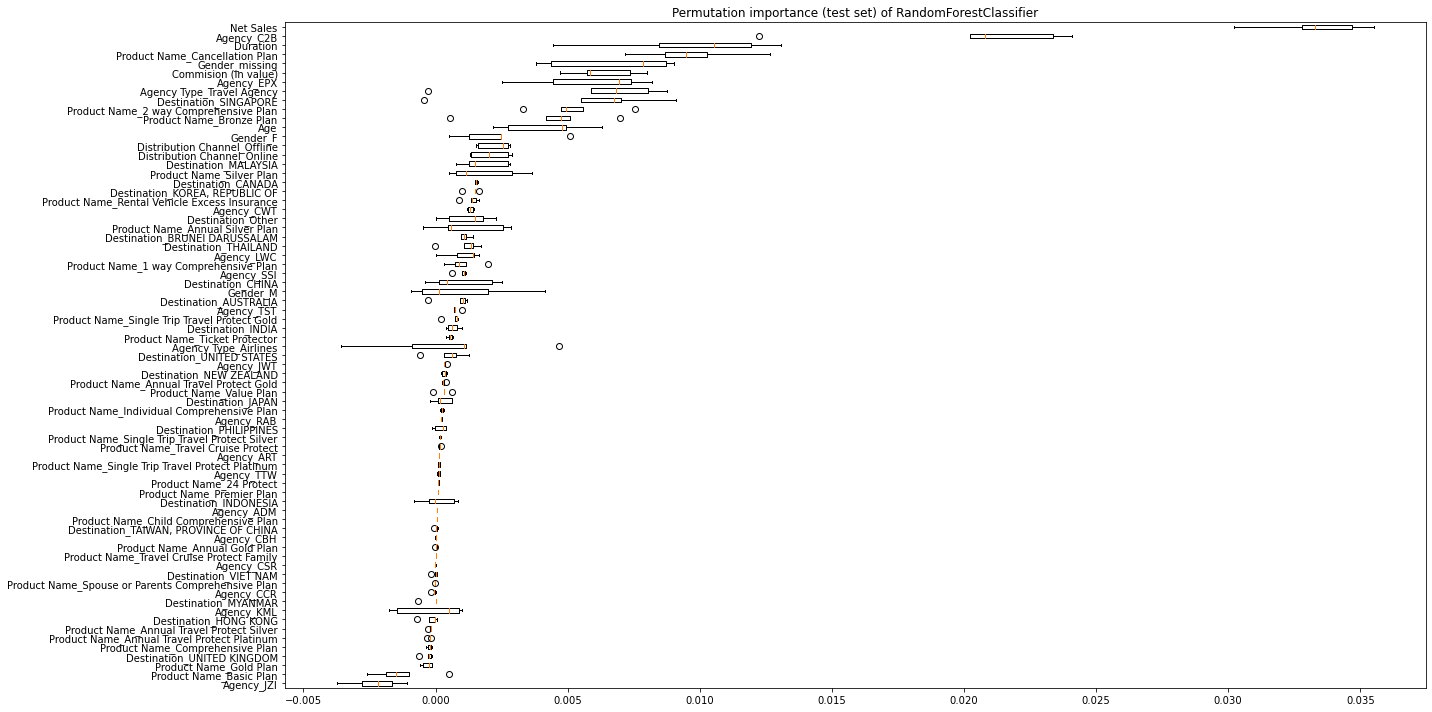

In [47]:
## We calculate the permutation importance on the test set in the same way as in the notebook for exercise 3.
## We can see that net sales is especially important.
## - Due to the high computation time, we can show the result "feature_importance.png" in the tutorial.
plt.rcParams['figure.figsize'] = 20, 10
perm_imp = permutation_importance(rf, X_test, y_test, scoring='roc_auc', random_state=123)
sorted_idx = perm_imp.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation importance (test set) of {}".format(str(rf)[0:str(rf).find('(')]))
fig.tight_layout()
plt.show()

C:\Users\bjoer\anaconda3\envs\adams\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


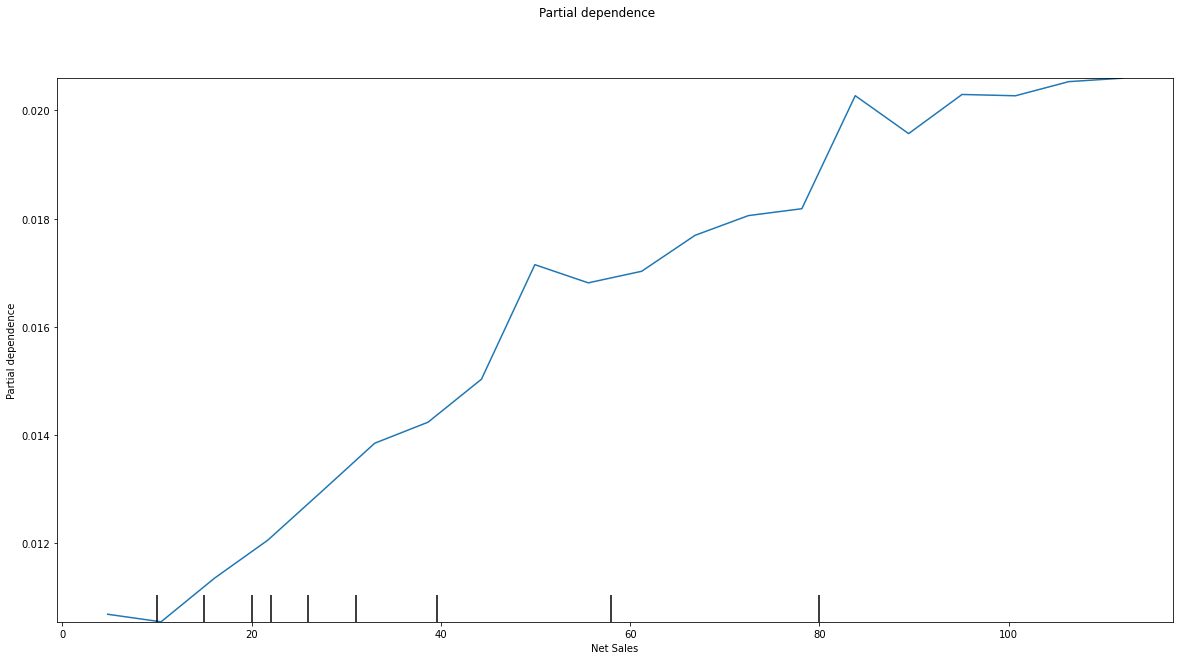

In [46]:
## We calculate the partial dependence plot in the same way as in the notebook for exercise 3.
## The probability of "claim" increases with net sales. 
## - Due to the high computation time, we can show the result "Partial_Dependence.png" in the tutorial.
plt.rcParams['figure.figsize'] = 20,10
plot_partial_dependence(rf, X_test, features=['Net Sales'], n_jobs=3, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()